In [ ]:
# Step 1: Install Required Libraries
!pip install tensorflow numpy matplotlib opencv-python scikit-learn seaborn kaggle


In [ ]:
# Step 2: Import all required libraries
import os
import random
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras import regularizers


In [ ]:
# Step 3: Kaggle dataset setup (upload kaggle.json first)
from google.colab import files
files.upload()  # Upload your kaggle.json

os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
shutil.copy('kaggle.json', os.path.expanduser('~/.kaggle/kaggle.json'))
os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)

!kaggle datasets download -d xhlulu/140k-real-and-fake-faces
!unzip -q 140k-real-and-fake-faces.zip

# Prepare directories and copy subset of images
os.makedirs('dataset/train/real', exist_ok=True)
os.makedirs('dataset/train/fake', exist_ok=True)
os.makedirs('dataset/val/real', exist_ok=True)
os.makedirs('dataset/val/fake', exist_ok=True)
os.makedirs('dataset/test/real', exist_ok=True)
os.makedirs('dataset/test/fake', exist_ok=True)

def copy_subset(source_dir, target_dir, num_files):
    files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    selected = random.sample(files, min(num_files, len(files)))
    for file in selected:
        shutil.copy(os.path.join(source_dir, file), target_dir)

copy_subset('real_vs_fake/real-vs-fake/train/real', 'dataset/train/real', 14700)
copy_subset('real_vs_fake/real-vs-fake/train/fake', 'dataset/train/fake', 14700)
copy_subset('real_vs_fake/real-vs-fake/valid/real', 'dataset/val/real', 3150)
copy_subset('real_vs_fake/real-vs-fake/valid/fake', 'dataset/val/fake', 3150)
copy_subset('real_vs_fake/real-vs-fake/test/real', 'dataset/test/real', 3150)
copy_subset('real_vs_fake/real-vs-fake/test/fake', 'dataset/test/fake', 3150)


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.75G/3.75G [00:32<00:00, 108MB/s] 
100% 3.75G/3.75G [00:32<00:00, 122MB/s]


In [ ]:

# Step 4: Frequency domain preprocessing
def add_frequency_channels(image):

    # Convert to float32 and normalize to [0,1]
    image = image.astype(np.float32) / 255.0

    # Process frequency domain
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    dft = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    real = dft_shift[:, :, 0]
    imag = dft_shift[:, :, 1]

    magnitude = cv2.magnitude(real, imag)
    phase = cv2.phase(real, imag)

    magnitude = np.log(magnitude + 1)
    magnitude = cv2.normalize(magnitude, None, 0, 1, cv2.NORM_MINMAX)
    phase = (phase + np.pi) / (2 * np.pi)

    magnitude = np.expand_dims(magnitude, axis=-1)
    phase = np.expand_dims(phase, axis=-1)

    combined = np.concatenate([image, magnitude, phase], axis=-1)
    return combined

In [ ]:
 # Step 5: Custom data generator
class FrequencyDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, target_size=(160, 160), batch_size=32, shuffle=True, augment=False):
        self.directory = directory
        self.target_size = target_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.image_paths = []
        self.labels = []

        # Collect all image paths and labels
        for label in ['real', 'fake']:
            label_dir = os.path.join(directory, label)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(0 if label == 'real' else 1)

        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            # Load and preprocess image
            img = tf.keras.preprocessing.image.load_img(
                self.image_paths[i],
                target_size=self.target_size
            )
            img = tf.keras.preprocessing.image.img_to_array(img)

            # Apply frequency transformation
            img = add_frequency_channels(img)

            # Apply augmentations if needed
            if self.augment:
                if np.random.rand() < 0.5:
                    img = tf.image.random_brightness(img, max_delta=0.2).numpy()
                if np.random.rand() < 0.5:
                    img = tf.image.random_contrast(img, lower=0.8, upper=1.2).numpy()
                if np.random.rand() < 0.3:
                    noise = np.random.normal(0, 0.05, img.shape)
                    img = np.clip(img + noise, 0, 1)

            batch_images.append(img)
            batch_labels.append(self.labels[i])

        return np.array(batch_images), np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [ ]:
# Step 6: Create data generators
INPUT_SIZE = (160, 160)
BATCH_SIZE = 32

train_generator = FrequencyDataGenerator(
    'dataset/train',
    target_size=INPUT_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True
)

val_generator = FrequencyDataGenerator(
    'dataset/val',
    target_size=INPUT_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    augment=False
)

test_generator = FrequencyDataGenerator(
    'dataset/test',
    target_size=INPUT_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    augment=False
)

In [ ]:
 # Step 7: Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.labels),
    y=train_generator.labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(1.0), 1: np.float64(1.0)}


In [ ]:
# Step 8: Use built-in Binary Crossentropy loss
loss_function = tf.keras.losses.BinaryCrossentropy()

In [ ]:
# Step 9: Custom F1 metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

f1_metric = F1Score()

In [ ]:
# Step 10: Build CNN model
def build_model():
    model = Sequential([
        Conv2D(32, (3,3), padding='same', input_shape=(INPUT_SIZE[0], INPUT_SIZE[1], 5)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(2,2),
        Dropout(0.25),

        Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Conv2D(128, (3,3), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(2,2),
        Dropout(0.3),

        Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Conv2D(256, (3,3), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(2,2),
        Dropout(0.4),

        Flatten(),
        Dense(512, kernel_regularizer=regularizers.l2(1e-4)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.5),

        Dense(1, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), f1_metric]
    )
    return model

model = build_model()
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 160, 160, 32)   │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 160, 160, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 40, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 20, 20, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 20, 20, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 20, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 20, 20, 256)    │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 14,240,385 (54.32 MB)

 Trainable params: 14,237,633 (54.31 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [ ]:
# Step 11: Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_f1_score', mode='max', save_best_only=True, verbose=1)

In [ ]:
# Step 12: Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.5756 - f1_score: 0.4592 - loss: 0.2410 - precision_1: 0.6414 - recall_1: 0.3597
Epoch 1: val_f1_score improved from -inf to 0.21881, saving model to best_model.h5


919/919 ━━━━━━━━━━━━━━━━━━━━ 275s 279ms/step - accuracy: 0.5756 - f1_score: 0.4593 - loss: 0.2410 - precision_1: 0.6415 - recall_1: 0.3597 - val_accuracy: 0.5557 - val_f1_score: 0.2188 - val_loss: 0.1524 - val_precision_1: 0.9053 - val_recall_1: 0.1244 - learning_rate: 0.0010
Epoch 2/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.6794 - f1_score: 0.6150 - loss: 0.1178 - precision_1: 0.7681 - recall_1: 0.5128
Epoch 2: val_f1_score improved from 0.21881 to 0.68409, saving model to best_model.h5


919/919 ━━━━━━━━━━━━━━━━━━━━ 298s 265ms/step - accuracy: 0.6794 - f1_score: 0.6150 - loss: 0.1178 - precision_1: 0.7681 - recall_1: 0.5128 - val_accuracy: 0.7371 - val_f1_score: 0.6841 - val_loss: 0.0850 - val_precision_1: 0.8571 - val_recall_1: 0.5692 - learning_rate: 0.0010
Epoch 3/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.7277 - f1_score: 0.6849 - loss: 0.0883 - precision_1: 0.8197 - recall_1: 0.5883
Epoch 3: val_f1_score improved from 0.68409 to 0.68544, saving model to best_model.h5


919/919 ━━━━━━━━━━━━━━━━━━━━ 264s 287ms/step - accuracy: 0.7277 - f1_score: 0.6849 - loss: 0.0883 - precision_1: 0.8197 - recall_1: 0.5883 - val_accuracy: 0.7394 - val_f1_score: 0.6854 - val_loss: 0.0816 - val_precision_1: 0.8643 - val_recall_1: 0.5679 - learning_rate: 0.0010
Epoch 4/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.7704 - f1_score: 0.7392 - loss: 0.0767 - precision_1: 0.8531 - recall_1: 0.6521
Epoch 4: val_f1_score did not improve from 0.68544
919/919 ━━━━━━━━━━━━━━━━━━━━ 231s 251ms/step - accuracy: 0.7704 - f1_score: 0.7392 - loss: 0.0767 - precision_1: 0.8531 - recall_1: 0.6521 - val_accuracy: 0.7414 - val_f1_score: 0.6636 - val_loss: 0.0847 - val_precision_1: 0.9492 - val_recall_1: 0.5102 - learning_rate: 0.0010
Epoch 5/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.7958 - f1_score: 0.7703 - loss: 0.0729 - precision_1: 0.8774 - recall_1: 0.6866
Epoch 5: val_f1_score improved from 0.68544 to 0.70992, saving model to best_model.h5


919/919 ━━━━━━━━━━━━━━━━━━━━ 231s 251ms/step - accuracy: 0.7958 - f1_score: 0.7704 - loss: 0.0729 - precision_1: 0.8774 - recall_1: 0.6866 - val_accuracy: 0.7694 - val_f1_score: 0.7099 - val_loss: 0.0850 - val_precision_1: 0.9564 - val_recall_1: 0.5644 - learning_rate: 0.0010
Epoch 6/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.8130 - f1_score: 0.7941 - loss: 0.0714 - precision_1: 0.8922 - recall_1: 0.7155
Epoch 6: val_f1_score improved from 0.70992 to 0.84587, saving model to best_model.h5


919/919 ━━━━━━━━━━━━━━━━━━━━ 262s 251ms/step - accuracy: 0.8130 - f1_score: 0.7941 - loss: 0.0714 - precision_1: 0.8922 - recall_1: 0.7155 - val_accuracy: 0.8543 - val_f1_score: 0.8459 - val_loss: 0.0684 - val_precision_1: 0.8977 - val_recall_1: 0.7997 - learning_rate: 0.0010
Epoch 7/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.8279 - f1_score: 0.8127 - loss: 0.0718 - precision_1: 0.9064 - recall_1: 0.7367
Epoch 7: val_f1_score did not improve from 0.84587
919/919 ━━━━━━━━━━━━━━━━━━━━ 240s 262ms/step - accuracy: 0.8279 - f1_score: 0.8127 - loss: 0.0718 - precision_1: 0.9064 - recall_1: 0.7367 - val_accuracy: 0.7071 - val_f1_score: 0.5875 - val_loss: 0.1069 - val_precision_1: 0.9932 - val_recall_1: 0.4171 - learning_rate: 0.0010
Epoch 8/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.8386 - f1_score: 0.8222 - loss: 0.0688 - precision_1: 0.9122 - recall_1: 0.7484
Epoch 8: val_f1_score did not improve from 0.84587
919/919 ━━━━━━━━━━━━━━━━━━━━ 245s 266ms/step - a

919/919 ━━━━━━━━━━━━━━━━━━━━ 238s 259ms/step - accuracy: 0.8591 - f1_score: 0.8466 - loss: 0.0616 - precision_1: 0.9207 - recall_1: 0.7837 - val_accuracy: 0.8948 - val_f1_score: 0.8892 - val_loss: 0.0539 - val_precision_1: 0.9386 - val_recall_1: 0.8448 - learning_rate: 0.0010
Epoch 11/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8677 - f1_score: 0.8580 - loss: 0.0545 - precision_1: 0.9314 - recall_1: 0.7952
Epoch 11: val_f1_score did not improve from 0.88922
919/919 ━━━━━━━━━━━━━━━━━━━━ 234s 255ms/step - accuracy: 0.8677 - f1_score: 0.8580 - loss: 0.0545 - precision_1: 0.9314 - recall_1: 0.7952 - val_accuracy: 0.8770 - val_f1_score: 0.8837 - val_loss: 0.0631 - val_precision_1: 0.8382 - val_recall_1: 0.9343 - learning_rate: 0.0010
Epoch 12/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8693 - f1_score: 0.8610 - loss: 0.0529 - precision_1: 0.9295 - recall_1: 0.8019
Epoch 12: val_f1_score did not improve from 0.88922
919/919 ━━━━━━━━━━━━━━━━━━━━ 230s 251ms/step

919/919 ━━━━━━━━━━━━━━━━━━━━ 239s 260ms/step - accuracy: 0.8868 - f1_score: 0.8796 - loss: 0.0417 - precision_1: 0.9419 - recall_1: 0.8251 - val_accuracy: 0.8935 - val_f1_score: 0.8960 - val_loss: 0.0495 - val_precision_1: 0.8753 - val_recall_1: 0.9178 - learning_rate: 0.0010
Epoch 17/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8936 - f1_score: 0.8861 - loss: 0.0383 - precision_1: 0.9475 - recall_1: 0.8323
Epoch 17: val_f1_score did not improve from 0.89602
919/919 ━━━━━━━━━━━━━━━━━━━━ 239s 260ms/step - accuracy: 0.8936 - f1_score: 0.8861 - loss: 0.0383 - precision_1: 0.9475 - recall_1: 0.8323 - val_accuracy: 0.8284 - val_f1_score: 0.7948 - val_loss: 0.0523 - val_precision_1: 0.9887 - val_recall_1: 0.6644 - learning_rate: 0.0010
Epoch 18/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8908 - f1_score: 0.8839 - loss: 0.0377 - precision_1: 0.9451 - recall_1: 0.8303
Epoch 18: val_f1_score improved from 0.89602 to 0.89809, saving model to best_model.h5


919/919 ━━━━━━━━━━━━━━━━━━━━ 234s 255ms/step - accuracy: 0.8908 - f1_score: 0.8839 - loss: 0.0377 - precision_1: 0.9451 - recall_1: 0.8303 - val_accuracy: 0.9059 - val_f1_score: 0.8981 - val_loss: 0.0371 - val_precision_1: 0.9790 - val_recall_1: 0.8295 - learning_rate: 0.0010
Epoch 19/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8917 - f1_score: 0.8845 - loss: 0.0375 - precision_1: 0.9427 - recall_1: 0.8330
Epoch 19: val_f1_score improved from 0.89809 to 0.89861, saving model to best_model.h5


919/919 ━━━━━━━━━━━━━━━━━━━━ 233s 253ms/step - accuracy: 0.8917 - f1_score: 0.8845 - loss: 0.0375 - precision_1: 0.9427 - recall_1: 0.8330 - val_accuracy: 0.8925 - val_f1_score: 0.8986 - val_loss: 0.0433 - val_precision_1: 0.8506 - val_recall_1: 0.9524 - learning_rate: 0.0010
Epoch 20/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9021 - f1_score: 0.8971 - loss: 0.0317 - precision_1: 0.9504 - recall_1: 0.8495
Epoch 20: val_f1_score did not improve from 0.89861
919/919 ━━━━━━━━━━━━━━━━━━━━ 231s 252ms/step - accuracy: 0.9020 - f1_score: 0.8971 - loss: 0.0317 - precision_1: 0.9504 - recall_1: 0.8495 - val_accuracy: 0.8841 - val_f1_score: 0.8931 - val_loss: 0.0493 - val_precision_1: 0.8290 - val_recall_1: 0.9679 - learning_rate: 0.0010


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # Original 20 + 10 more
    initial_epoch=20,  # Start from epoch 21
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

Epoch 21/30
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8979 - f1_score: 0.8918 - loss: 0.0395 - precision_1: 0.9519 - recall_1: 0.8389
Epoch 21: val_f1_score did not improve from 0.89861
919/919 ━━━━━━━━━━━━━━━━━━━━ 233s 254ms/step - accuracy: 0.8979 - f1_score: 0.8918 - loss: 0.0395 - precision_1: 0.9519 - recall_1: 0.8389 - val_accuracy: 0.9038 - val_f1_score: 0.8980 - val_loss: 0.0374 - val_precision_1: 0.9559 - val_recall_1: 0.8467 - learning_rate: 0.0010
Epoch 22/30
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.8984 - f1_score: 0.8921 - loss: 0.0346 - precision_1: 0.9500 - recall_1: 0.8408
Epoch 22: val_f1_score did not improve from 0.89861
919/919 ━━━━━━━━━━━━━━━━━━━━ 237s 258ms/step - accuracy: 0.8984 - f1_score: 0.8921 - loss: 0.0346 - precision_1: 0.9500 - recall_1: 0.8408 - val_accuracy: 0.8140 - val_f1_score: 0.7716 - val_loss: 0.0537 - val_precision_1: 0.9990 - val_recall_1: 0.6286 - learning_rate: 0.0010
Epoch 23/30
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 

919/919 ━━━━━━━━━━━━━━━━━━━━ 235s 256ms/step - accuracy: 0.9044 - f1_score: 0.8980 - loss: 0.0299 - precision_1: 0.9509 - recall_1: 0.8507 - val_accuracy: 0.9144 - val_f1_score: 0.9113 - val_loss: 0.0311 - val_precision_1: 0.9460 - val_recall_1: 0.8790 - learning_rate: 0.0010
Epoch 25/30
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9063 - f1_score: 0.9021 - loss: 0.0300 - precision_1: 0.9544 - recall_1: 0.8552
Epoch 25: val_f1_score did not improve from 0.91130
919/919 ━━━━━━━━━━━━━━━━━━━━ 239s 260ms/step - accuracy: 0.9063 - f1_score: 0.9021 - loss: 0.0300 - precision_1: 0.9544 - recall_1: 0.8552 - val_accuracy: 0.9121 - val_f1_score: 0.9067 - val_loss: 0.0304 - val_precision_1: 0.9656 - val_recall_1: 0.8546 - learning_rate: 0.0010
Epoch 26/30
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9061 - f1_score: 0.9016 - loss: 0.0301 - precision_1: 0.9506 - recall_1: 0.8574
Epoch 26: val_f1_score improved from 0.91130 to 0.92789, saving model to best_model.h5


919/919 ━━━━━━━━━━━━━━━━━━━━ 234s 254ms/step - accuracy: 0.9061 - f1_score: 0.9016 - loss: 0.0301 - precision_1: 0.9506 - recall_1: 0.8574 - val_accuracy: 0.9287 - val_f1_score: 0.9279 - val_loss: 0.0306 - val_precision_1: 0.9389 - val_recall_1: 0.9171 - learning_rate: 0.0010
Epoch 27/30
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9071 - f1_score: 0.9018 - loss: 0.0288 - precision_1: 0.9517 - recall_1: 0.8569
Epoch 27: val_f1_score did not improve from 0.92789
919/919 ━━━━━━━━━━━━━━━━━━━━ 235s 256ms/step - accuracy: 0.9071 - f1_score: 0.9018 - loss: 0.0288 - precision_1: 0.9517 - recall_1: 0.8569 - val_accuracy: 0.9086 - val_f1_score: 0.9008 - val_loss: 0.0310 - val_precision_1: 0.9846 - val_recall_1: 0.8302 - learning_rate: 0.0010
Epoch 28/30
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9059 - f1_score: 0.9015 - loss: 0.0301 - precision_1: 0.9484 - recall_1: 0.8591
Epoch 28: val_f1_score did not improve from 0.92789
919/919 ━━━━━━━━━━━━━━━━━━━━ 241s 262ms/step

In [ ]:
# Step 13: Load best weights
model.load_weights('best_model.h5')



In [ ]:
# Step 14: Evaluate on test set
test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test precision: {test_precision:.4f}")
print(f"Test recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")


197/197 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.9353 - f1_score: 0.4331 - loss: 0.0327 - precision_1: 0.4135 - recall_1: 0.4684
Test accuracy: 0.9322
Test precision: 0.9379
Test recall: 0.9257
Test F1-score: 0.9318


In [ ]:
# Step 15: Generate predictions
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)
y_true = np.concatenate([test_generator[i][1] for i in range(len(test_generator))])

print(classification_report(y_true, y_pred, target_names=['real', 'fake']))

197/197 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step
              precision    recall  f1-score   support

        real       0.93      0.94      0.93      3150
        fake       0.94      0.93      0.93      3150

    accuracy                           0.93      6300
   macro avg       0.93      0.93      0.93      6300
weighted avg       0.93      0.93      0.93      6300



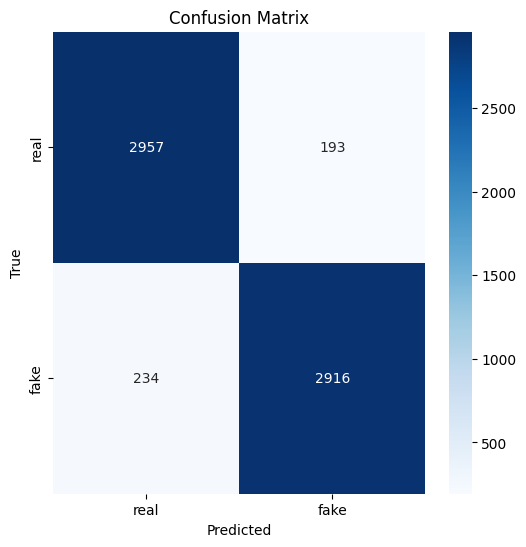

In [ ]:
# Step 16: Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['real', 'fake'], yticklabels=['real', 'fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

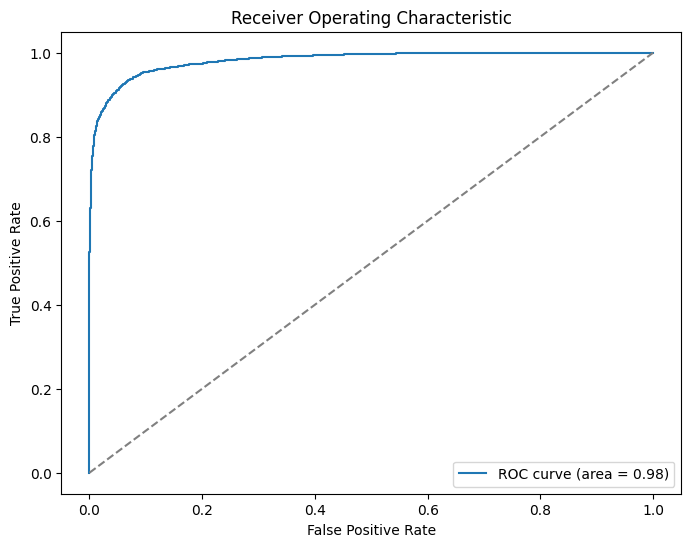

In [ ]:
# Step 17: ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.save("my_model.h5")  # Save in HDF5 format

In [ ]:
from google.colab import files
files.download("my_model.h5")  # For HDF5 format


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>